In [200]:
import ibis
from ibis import _
import matplotlib.pyplot as plt      

In [87]:

db_file = "/mnt/ssd/AcademicGraph/AcademicGraph.sqlite" 
ibis.options.interactive = True
con = ibis.connect(db_file)

max_level = 2
field_to_query = 95457728
degree_year_to_query = 2001



links_to_cng = con.table("links_to_cng")
affiliations = con.table("affiliations")
fields_of_study = con.table("FieldsOfStudy")

current_links = con.table("current_links")
pq_authors = con.table("pq_authors")
pq_fields_mag = con.table("pq_fields_mag")
pq_magfos = con.table("pq_magfos")

author_affiliation = con.table("AuthorAffiliation")
author_fields = con.table("author_fields")


paper_author_unique = con.table("PaperAuthorUnique")
papers = con.table("Papers")
author_fields_detailed = con.table("author_fields_detailed")

affiliation_fields = con.table("affiliation_fields")
affiliation_outcomes = con.table("affiliation_outcomes")


In [88]:
# load all the queries as in the existing file
query_affiliations = (
    affiliations
    .join(
        links_to_cng,
        affiliations.AffiliationId == links_to_cng.from_id
    )
    .filter(
        links_to_cng.from_dataset == "mag"
    )
    .select(
        _.AffiliationId
    )
)

query_fields_up_to_max_level = (
    fields_of_study
    .filter(
        _.Level <= max_level
    )
    .select(
        _.FieldOfStudyId
    )
)

query_graduates = (
    current_links
    .join(
        pq_authors,
        "goid",
        how="inner"
    )
    .filter(
        pq_authors.degree_year == degree_year_to_query
    )
    .join(
        pq_fields_mag
        .mutate(
            row_num=ibis
                .row_number()
                .over(group_by=_.goid, order_by=_.position.asc()
            )
        )
        .filter(
            [_.row_num == 0, _.mag_field0 == field_to_query]
        )
        .select(
            _.goid,
            _.position,
            Field0 = _.mag_field0
        ),
        "goid"
    )
    .select(
        _.goid,
        _.AuthorId,
        _.degree_year,
        _.Field0
    )
)
        
query_topics_dissertation = (
    pq_magfos
    .join(
        query_graduates,
        "goid",
        how="inner"
    )
    .join(
        query_fields_up_to_max_level,
        "FieldOfStudyId",
        how="inner"
    )
)

#topics_dissertation = query_topics_dissertation.execute() # this allows us to compute the first topic vector
# need to extend it to "all" possible topics, and pivot_wide
# in 2001, we have 686 concepts? 

query_collaborators = (
    author_affiliation
    .join(
        query_affiliations,
        "AffiliationId",
        how="inner"
    )
    .join(
        author_fields
        .filter(
            [_.FieldClass == "main", _.FieldOfStudyId == field_to_query]
        )
        .select(
            _.AuthorId
        ),
        "AuthorId",
        how="inner"
    ).
    filter(
        [_.Year <= degree_year_to_query + 5, # TODO: careful with years here!
         _.Year >= degree_year_to_query - 5] 
    )
)

query_author_papers = (
    paper_author_unique
    .join(
        papers
        .filter(
            _.DocType == "Journal"
        )
        .select(
            _.PaperId,
            _.Year
        ),
        "PaperId",
        how="inner"
    )
    .join(
        query_collaborators
        .select(_.AuthorId),
        "AuthorId",
        how="inner"
    )
    .filter(
        [_.Year <= degree_year_to_query + 5,
        _.Year >= degree_year_to_query - 5]
    )
    .select(
        _.PaperId,
        _.AuthorId,
        _.Year
    )
)




query_collaborators_topics = (
    author_fields_detailed
    .join(
        author_fields
        .filter(
            _.FieldClass == "main"
        )
        .select(
            _.AuthorId,
            Field0 = _.FieldOfStudyId
        ),
        "AuthorId",
        how="inner"
    ).
    join(
        query_collaborators
        .select(_.AuthorId),
        "AuthorId",
        how="inner"
    )
    .join(
        query_fields_up_to_max_level,
        "FieldOfStudyId",
        how="inner"
    )
    .mutate(
        Score = _.Score / _.PaperCount
    )
    .filter(
        [_.Year <= degree_year_to_query + 5,
         _.Year >= degree_year_to_query - 5]
    )
    .select(
        _.AuthorId,
        _.FieldOfStudyId,
        _.Year,
        _.Field0,
        _.PaperCount,
        _.Score
    )
)


query_affiliation_topics = (
        affiliation_fields
        .join(
            affiliation_outcomes
            .select(
                _.AffiliationId,
                _.Field0,
                _.Year,
                _.PaperCount
            ),
            ["AffiliationId", "Year", "Field0",
             affiliation_fields.Field0 == field_to_query,
             affiliation_outcomes.Year <= degree_year_to_query + 5,
             affiliation_outcomes.Year >= degree_year_to_query - 5],
            how="inner"
        )
        .join(
            query_affiliations,
            "AffiliationId",
            how="inner"
        )
        .join( # subset to the relevant fields of study -- I think we forgot that previously
            query_fields_up_to_max_level,
            "FieldOfStudyId",
            how="inner"
        )
        .select(
            _.AffiliationId,
            _.Field0,
            _.Year,
            _.FieldOfStudyId,
            Score = _.Score / _.PaperCount
        )
)


In [89]:
query_affiliation_topics.head()

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ AffiliationId ┃ Field0   ┃ Year  ┃ FieldOfStudyId ┃ Score    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ int64         │ int64    │ int64 │ int64          │ float64  │
├───────────────┼──────────┼───────┼────────────────┼──────────┤
│     130701444 │ 95457728 │  1996 │       76155785 │ 0.431343 │
│     130701444 │ 95457728 │  1996 │      127413603 │ 0.411168 │
│     130701444 │ 95457728 │  1996 │     2776398702 │ 0.401332 │
│     130701444 │ 95457728 │  1996 │     2777683733 │ 0.449975 │
│     130701444 │ 95457728 │  1996 │     2780031656 │ 0.456387 │
└───────────────┴──────────┴───────┴────────────────┴──────────┘

In [90]:
query_graduates.head()

┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ goid      ┃ AuthorId  ┃ degree_year ┃ Field0   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ int64     │ int64     │ int64       │ int64    │
├───────────┼───────────┼─────────────┼──────────┤
│ 304697883 │  20514481 │        2001 │ 95457728 │
│ 304731168 │  73798689 │        2001 │ 95457728 │
│ 304692505 │  97269945 │        2001 │ 95457728 │
│ 304720798 │ 103099795 │        2001 │ 95457728 │
│ 275944833 │ 115250268 │        2001 │ 95457728 │
└───────────┴───────────┴─────────────┴──────────┘

In [91]:
query_topics_dissertation.head()

┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ goid      ┃ fieldrank ┃ FieldOfStudyId ┃ score   ┃ AuthorId ┃ degree_year ┃ Field0   ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ int64     │ int64     │ int64          │ float64 │ int64    │ int64       │ int64    │
├───────────┼───────────┼────────────────┼─────────┼──────────┼─────────────┼──────────┤
│ 304697883 │         2 │       94625758 │  0.5364 │ 20514481 │        2001 │ 95457728 │
│ 304697883 │         1 │      202565627 │  0.5537 │ 20514481 │        2001 │ 95457728 │
│ 304731168 │        10 │       17744445 │  0.4442 │ 73798689 │        2001 │ 95457728 │
│ 304731168 │         1 │       39853841 │  0.5339 │ 73798689 │        2001 │ 95457728 │
│ 304731168 │         8 │       95124753 │  0.4514 │ 73798689 │        2001 │ 95457728 │
└───────────┴───────────┴────────────────┴─────────┴──────────┴─────────────┴──────────┘

In [92]:
concepts_dissertation = (
    query_topics_dissertation
    .select(
        _.AuthorId,
        _.FieldOfStudyId,
        _.score
    )
)

In [93]:
concepts_dissertation = concepts_dissertation.execute()

In [94]:
concepts_dissertation.head()

,AuthorId,FieldOfStudyId,score
0,20514481,94625758,0.5364
1,20514481,202565627,0.5537
2,73798689,17744445,0.4442
3,73798689,39853841,0.5339
4,73798689,95124753,0.4514


In [95]:
concepts_dissertation.describe()

,AuthorId,FieldOfStudyId,score
count,1.855000e+03,1.855000e+03,1855.000000
mean,2.103080e+09,8.253521e+08,0.480156
std,6.133085e+08,1.171812e+09,0.038223
min,2.051448e+07,1.370556e+06,0.366000
25%,2.050481e+09,7.707779e+07,0.455400
50%,2.154136e+09,1.389217e+08,0.474100
75%,2.485259e+09,2.776051e+09,0.500750
max,2.998531e+09,3.020690e+09,0.668700


In [290]:
concepts_affiliations = (
    query_affiliation_topics
    .filter([_.Year < degree_year_to_query,
            _.Score > 0])
    .select(_.AffiliationId, _.FieldOfStudyId, score = _.Score)
)

In [291]:
concepts_affiliations = concepts_affiliations.execute()

In [292]:
concepts_affiliations.head()

,AffiliationId,FieldOfStudyId,score
0,130701444,76155785,0.431343
1,130701444,127413603,0.411168
2,130701444,2776398702,0.401332
3,130701444,2777683733,0.449975
4,130701444,2780031656,0.456387


In [293]:
fields_of_study = query_fields_up_to_max_level.execute()

In [294]:
fields_of_study.head()

,FieldOfStudyId
0,417682
1,1443462
2,3079626
3,4084960
4,8748842


In [295]:
fields_of_study.dtypes

FieldOfStudyId    int64
dtype: object

In [296]:
import numpy as np                                                                                                                                                                          
from scipy.sparse import csr_matrix                                                                                                                                                         
from sklearn.decomposition import TruncatedSVD  

In [297]:
concepts_affiliations.describe()

,AffiliationId,FieldOfStudyId,score
count,2.026500e+04,2.026500e+04,20265.000000
mean,1.201400e+08,7.409110e+08,0.147631
std,1.387701e+08,1.126991e+09,0.142217
min,3.922820e+05,4.070000e+04,0.007696
25%,5.720697e+07,7.490951e+07,0.041217
50%,1.046510e+08,1.399977e+08,0.091227
75%,1.545704e+08,5.315936e+08,0.207460
max,1.327163e+09,3.019993e+09,0.838451


In [298]:
concepts_affiliations["score"].values[:3]

array([0.43134296, 0.41116807, 0.4013321 ])

### Create sparse matrices

In [299]:

field_to_index = {id: index for index, id in enumerate(fields_of_study['FieldOfStudyId'].unique())}
field_to_index_map = np.vectorize(field_to_index.get)


In [300]:
# # reference for all fields of study
# field_to_index = {id: index for index, id in enumerate(fields_of_study['FieldOfStudyId'].unique())}
# field_to_index_map = np.vectorize(field_to_index.get)
# cols = field_to_index_map(np.array(concepts_affiliations["FieldOfStudyId"]))
# # concepts_affiliations["FieldOfStudyId"].map(fie?ld_to_index)
# assert cols.shape == np.array(concepts_affiliations["FieldOfStudyId"]).shape
# col_to_index_map = {id: index for index, id in enumerate(concepts_affiliations['AffiliationId'].unique())}
# affiliation_to_index_map = np.vectorize(col_to_index.get)
# rows = affiliation_to_index_map(np.array(concepts_affiliations["AffiliationId"]))
# assert rows.shape == np.array(concepts_affiliations["AffiliationId"]).shape
# a = csr_matrix(
#     (np.array(concepts_affiliations["score"]), (rows, cols)),
#     shape=(rows.shape[0], len(field_to_index)))

In [321]:
def make_sparse(long_df, field_to_index, rows="AffiliationId", cols="FieldOfStudyId", value_col="score"): 
    # col = concepts_affiliations['AffiliationId']
    # row = 
    """Create sparse matrix from a dataframe.

    Args:
        col (np.ndarray): values for index 0 in the resulting sparse matrix
        row (np.ndarray): values for index 1 in the resulting sparse matrix.
        row_map: mapping of all possible row values to identifiers.
        data: non-zero values to to fill the sparse matrix.  
    
    """ 

    row_values = np.array(long_df[rows])
    col_values = np.array(long_df[cols])
    data = np.array(long_df[value_col])
    print(data.shape)

    row_to_index = {id: index for index, id in enumerate(np.unique(row_values))}
    row_to_index_map = np.vectorize(row_to_index.get)

    field_to_index_map = np.vectorize(field_to_index.get)

    cols = field_to_index_map(col_values)
    rows = row_to_index_map(row_values)

    print(cols.shape)
    print(rows.shape)
    print(data.shape)

    out = csr_matrix((data, (rows, cols)),
                     shape=(len(row_to_index), len(field_to_index)),
                     dtype=np.int64)
    print(out.__repr__())
    return out
    
    
    

In [322]:
v_affiliations = make_sparse(
    concepts_affiliations, field_to_index, "AffiliationId", "FieldOfStudyId", "score")

(20265,)
(20265,)
(20265,)
(20265,)
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 15599 stored elements and shape (577, 137499)>


In [323]:
v_graduates = make_sparse(
    concepts_dissertation, field_to_index, "AuthorId", "FieldOfStudyId", "score")
    

(1855,)
(1855,)
(1855,)
(1855,)
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1855 stored elements and shape (240, 137499)>


In [304]:
def run_svd(in_matrix, n_components=50):
    # n_components = 100  # Number of dimensions to reduce to                                                                                                                                      
    svd = TruncatedSVD(n_components=n_components, random_state=42)                                                                                                                              
    embs = svd.fit_transform(in_matrix)     
    
    print(f"Original matrix shape: {embs.shape}")                                                                                                                                
    print(f"Reduced matrix shape: {embs.shape}")                                                                                                                                   
    print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")                       
    
    return svd

In [282]:
a = run_svd(v_affiliations, 10)

Original matrix shape: (577, 10)
Reduced matrix shape: (577, 10)
Explained variance ratio: nan


In [283]:
b = run_svd(v_graduates, 10)

Original matrix shape: (240, 10)
Reduced matrix shape: (240, 10)
Explained variance ratio: nan


In [284]:
vars(a)

{'algorithm': 'randomized',
 'n_components': 10,
 'n_iter': 5,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': 42,
 'tol': 0.0,
 'n_features_in_': 137499,
 'components_': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'explained_variance_': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'explained_variance_ratio_': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 'singular_values_': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

<Axes: >

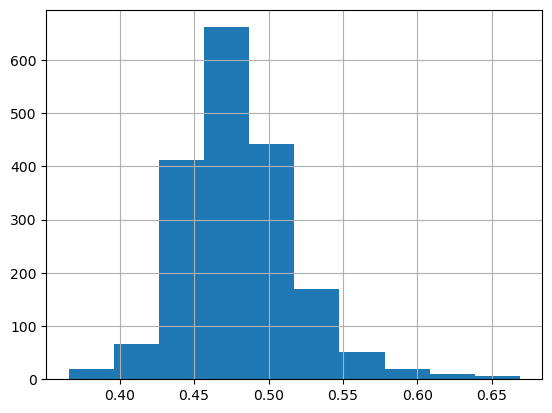

In [220]:
concepts_dissertation["score"].hist()

<Axes: >

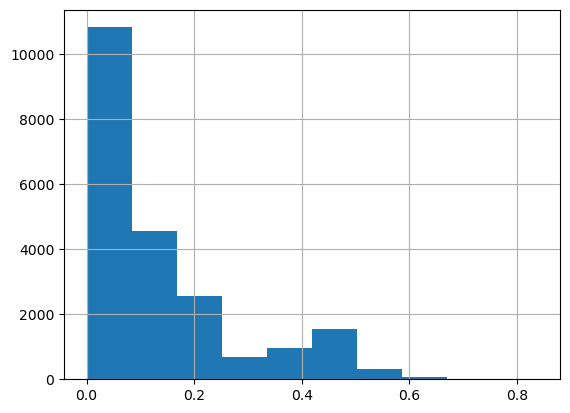

In [221]:
concepts_affiliations["score"].hist()

In [289]:
mask = concepts_affiliations["score"] > 0.
# WHY ARE THERE NOT 20k entries in the sparse matrix??
print(concepts_affiliations[mask].shape)
print(concepts_dissertation.shape)

(20265, 3)
(1855, 3)


In [231]:
concepts_dissertation["AuthorId"].nunique()

240

In [348]:
concepts_affiliations.head()

,AffiliationId,FieldOfStudyId,score
0,130701444,76155785,0.431343
1,130701444,127413603,0.411168
2,130701444,2776398702,0.401332
3,130701444,2777683733,0.449975
4,130701444,2780031656,0.456387


In [349]:
print(concepts_affiliations.shape)
print(concepts_affiliations.drop_duplicates(subset=["AffiliationId", "FieldOfStudyId"]).shape)

(20265, 3)
(15599, 3)


### Todo

- For author topics: what is Papers? do we need to divide the score by the number of papers?
- for concepts_affiliations: there are duplicated combinations of affiliationid - field of study id. why? -- fix!


[0.01570766 0.05122679 0.04998062 0.04795064 0.04539933]
0.21026503465070345
[35.24105443  4.5981613   4.54200434  4.44866153  4.32887456]


In [226]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

def create_sparse_matrix(df, field_to_id_map):
    """
    Create a sparse matrix from a DataFrame and a field-to-identifier mapping.
    
    Parameters:
    df (pd.DataFrame): DataFrame with columns ['identifier', 'field', 'score']
    field_to_id_map (dict): Mapping from field to identifier
    
    Returns:
    scipy.sparse.csr_matrix: The resulting sparse matrix
    dict: Mapping from original identifiers to matrix row indices
    list: List of fields corresponding to matrix columns
    """
    # Create mappings for identifiers and fields to indices
    unique_identifiers = df['identifier'].unique()
    id_to_index = {id: index for index, id in enumerate(unique_identifiers)}
    
    fields = list(field_to_id_map.keys())
    field_to_index = {field: index for index, field in enumerate(fields)}
    
    # Create vectorized mapping functions
    id_map = np.vectorize(id_to_index.get)
    field_map = np.vectorize(field_to_index.get)
    
    # Apply mappings
    rows = id_map(df['identifier'].values)
    cols = field_map(df['field'].values)
    data = df['score'].values
    
    # Check for and remove any None values (fields not in the mapping)
    mask = (rows != None) & (cols != None)
    rows = rows[mask]
    cols = cols[mask]
    data = data[mask]
    
    # Convert to proper types
    rows = rows.astype(int)
    cols = cols.astype(int)
    data = data.astype(float)
    
    # Create the sparse matrix
    matrix = csr_matrix((data, (rows, cols)), shape=(len(unique_identifiers), len(fields)))
    
    return matrix, id_to_index, fields

# Example usage:
# Sample data
data = {
    'identifier': ['A', 'A', 'B', 'C', 'C', 'D'],
    'field': ['f1', 'f2', 'f3', 'f1', 'f4', 'f2'],
    'score': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
}
df = pd.DataFrame(data)

# Sample field-to-identifier mapping
field_to_id_map = {'f1': 'F1', 'f2': 'F2', 'f3': 'F3', 'f4': 'F4', 'f5': 'F5'}

# Create the sparse matrix
sparse_matrix, id_to_index, fields = create_sparse_matrix(df, field_to_id_map)

print("Sparse matrix shape:", sparse_matrix.shape)
print("Number of non-zero elements:", sparse_matrix.nnz)
print("Identifier to index mapping:", id_to_index)
print("Fields:", fields)

# Convert to dense matrix for viewing (be careful with large matrices!)
dense_matrix = sparse_matrix.todense()
print("\nDense matrix:")
print(dense_matrix)

Sparse matrix shape: (4, 5)
Number of non-zero elements: 6
Identifier to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Fields: ['f1', 'f2', 'f3', 'f4', 'f5']

Dense matrix:
[[1. 2. 0. 0. 0.]
 [0. 0. 3. 0. 0.]
 [4. 0. 0. 5. 0.]
 [0. 6. 0. 0. 0.]]


In [326]:
sparse_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6 stored elements and shape (4, 5)>

In [327]:
df.shape

(6, 3)

In [329]:
concepts_affiliations.head()

,AffiliationId,FieldOfStudyId,score
0,130701444,76155785,0.431343
1,130701444,127413603,0.411168
2,130701444,2776398702,0.401332
3,130701444,2777683733,0.449975
4,130701444,2780031656,0.456387


In [335]:
dk = concepts_affiliations.rename(columns={"AffiliationId": "identifier", "FieldOfStudyId": "field"})
dk.head()
sparse_matrix, id_to_index, fields = create_sparse_matrix(dk, field_to_index)

In [342]:
(sparse_matrix != v_affiliations).sum()

np.int64(15599)

In [343]:
sparse_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 15599 stored elements and shape (577, 137499)>